In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
table = read_csv('/content/drive/MyDrive/QuadrantiCremona.csv')
table.head()

Unnamed: 0        Date  Ammonia  PM10  PM25  Wind_speed  Temperature  \
0           0  2014-02-12      6.5  54.0  44.0    0.479634     8.004167   
1           1  2014-02-13      8.3  52.0  43.0    1.035337     5.375000   
2           2  2014-02-14      7.7  43.0  36.0    1.061836     7.508333   
3           3  2014-02-15      9.6  41.0  35.0    0.452648     6.404167   
4           4  2014-02-16      7.4  67.0  59.0    0.771591     7.554167   

   Rainfall  Quadrante  
0       0.0          2  
1       0.6          1  
2       0.0          4  
3       0.0          4  
4       0.2          4

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = table.loc[:,["Date","PM10","PM25","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index        Date  PM10  PM25  Ammonia  Wind_speed  Quadrante  Temperature  \
0      0  2014-02-12  54.0  44.0      6.5    0.479634          2     8.004167   
1      1  2014-02-13  52.0  43.0      8.3    1.035337          1     5.375000   
2      2  2014-02-14  43.0  36.0      7.7    1.061836          4     7.508333   
3      3  2014-02-15  41.0  35.0      9.6    0.452648          4     6.404167   
4      4  2014-02-16  67.0  59.0      7.4    0.771591          4     7.554167   

   Rainfall  
0       0.0  
1       0.6  
2       0.0  
3       0.0  
4       0.2

In [ ]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [ ]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.292398   0.276730   0.155388   0.124610   0.333333   0.310002   
6   0.280702   0.270440   0.200501   0.270771   0.000000   0.234159   
7   0.228070   0.226415   0.185464   0.277741   1.000000   0.295699   
8   0.216374   0.220126   0.233083   0.117512   1.000000   0.263847   
9   0.368421   0.371069   0.177945   0.201400   1.000000   0.297021   

   var7(t-5)  var1(t-4)  var2(t-4)  var3(t-4)  ...  var7(t-2)  var1(t-1)  \
5   0.000000   0.280702   0.270440   0.200501  ...   0.000000   0.368421   
6   0.007426   0.228070   0.226415   0.185464  ...   0.002475   0.292398   
7   0.000000   0.216374   0.220126   0.233083  ...   0.044554   0.298246   
8   0.000000   0.368421   0.371069   0.177945  ...   0.000000   0.181287   
9   0.002475   0.292398   0.276730   0.180451  ...   0.113861   0.099415   

   var2(t-1)  var3(t-1)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
5   0.371069   0.177945  0.276730  0.180451  0.208162  1.000000  0.327070   
6   0.276730   0.180451  0.226415  0.235589  0.028907  0.000000  0.273824   
7   0.226415   0.235589  0.188679  0.215539  0.210324  1.000000  0.324666   
8   0.188679   0.215539  0.094340  0.135338  0.120864  0.333333  0.335724   
9   0.094340   0.135338  0.226415  0.142857  0.133990  0.666667  0.343416   

    var7(t)  
5  0.044554  
6  0.000000  
7  0.113861  
8  0.044554  
9  0.032178  

[5 rows x 37 columns]

In [ ]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first 1312 days
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 35) 1312 (1312,)
(1312, 5, 7) (1312,) (568, 5, 7) (568,)


# Modeling and training

In [ ]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/500
14/14 - 10s - loss: 0.0277 - val_loss: 0.0309 - 10s/epoch - 694ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0269 - val_loss: 0.0285 - 262ms/epoch - 19ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0245 - val_loss: 0.0295 - 250ms/epoch - 18ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0239 - val_loss: 0.0293 - 303ms/epoch - 22ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0249 - val_loss: 0.0292 - 262ms/epoch - 19ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0241 - val_loss: 0.0281 - 270ms/epoch - 19ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0233 - val_loss: 0.0280 - 268ms/epoch - 19ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0232 - val_loss: 0.0282 - 265ms/epoch - 19ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0231 - val_loss: 0.0282 - 258ms/epoch - 18ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0232 - val_loss: 0.0281 - 272ms/epoch - 19ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0232 - val_loss: 0.0287 - 246ms/epoch - 18ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0238 - val_loss: 0.0278 - 249ms/epoch - 18ms/step
E

## Predictions of the year 2019

In [ ]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.227


#### Prediciton plots

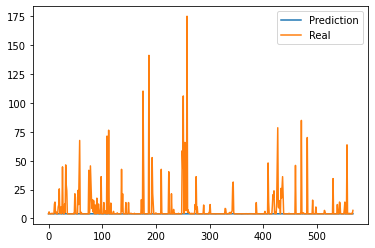

In [ ]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

# Modeling with hyperparamenter search
# Goal: reduce the MSE without overfitting

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt #Keras Creates a better model

In [ ]:
tf.config.list_physical_devices('GPU') #To undestand which GPU using during the training

[]

## Function to create new models

In [ ]:
def model_builder(hp):
  #design network
  #object created with keras_tuner -> iterates some parameters to create the model
  #units = neurons we use 32 steps for each time
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  #Initialization of the model
  model = Sequential() 
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  #for loop to iterate different quantities of layer (from 1 to 3 layer)
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  #Choose from a list of given instructions -> we choose leanrning rates
  #We look the performances
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

# Creation of the object with model_builder(hp)
## Parameter to look at: validation loss

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project dir/namee/oracle.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |288               |?                 
layers            |2                 |?                 
learning_rate     |0.001             |?                 

Epoch 1/100
12/19 [=================>............] - ETA: 2s - loss: 0.0353

In [ ]:
tuner.results_summary()

### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])